<h5 align="left">IBM Machine Learning Course - Deep learning Final Project</h5>

<h2 align="center">Exploring convolution neural networks with Chinese-MNIST</h2>

### Major objective of the analysis  

For this exercise, we will be using [Chinese-MNIST](https://www.kaggle.com/datasets/gpreda/chinese-mnist) dataset from kaggle.com. This dataset has 15000 grayscale images of hand-written Chinese characters of numbers.  

We will use this relatively small image set for  
-  Classification task with convolutional neural networks (CNNs) with various architectures from groud up;
-  Classification tast with transfer learning using a pretrained image classification model with some modifications.

Our major goal is to learn and explore CNNs with the dataset.

In [4]:
import pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization

# import warnings
# warnings.simplefilter('ignore')
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

### The dataset  

The dataset has 15000 grayscale images, each representing one character from a set of 15 Chinese number characters. The characters were written by 100 volunteers, each contributing 10 samples for each character. The original images were scanned at a resolution of 300 x 300 pixels. The images in the dataset are in 64 x 64 pixels resolution. The kaggle data were contributed by Gabriel Preda with original project from [Handwritten Chinese Numbers](https://data.ncl.ac.uk/articles/dataset/Handwritten_Chinese_Numbers/10280831/1).  

### Exploratry data analysis and feature engineering  

We first look at the info Excel file, which listed image related information and mapping of numbers to characters. We need information about the image names for reference, so we add image names to the info table. Additionally, the values of the “big” characters could be an issue as classification labels. Therefore, we added a column of image names by combining the suite_id, sample_id, and code, and a “label” column changing “100” to “11”, “1000” to “12”, “10000” to “13”, and “100000000” to “14”. We reset the index but keep the original index as reference.  

In [5]:
# Info
data_info = pd.read_csv('chinese_mnist/chinese_mnist.csv')
data_info.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [6]:
# Make a copy of info for processing.
# Add the image name to the info file.
df = data_info.copy() 
df['image_name'] = [f'input_{df.suite_id[i]}_{df.sample_id[i]}_{df.code[i]}.jpg' for i in range(len(df))]
df = df.sort_values(by = ['suite_id', 'sample_id', 'code', 'value', 'image_name'])
df = df.reset_index().rename({'index': 'ori_index'})
df.rename(columns={'index': 'ori_index'}, inplace=True)
df.head()

,ori_index,suite_id,sample_id,code,value,character,image_name
0,6000,1,1,1,0,零,input_1_1_1.jpg
1,7000,1,1,2,1,一,input_1_1_2.jpg
2,8000,1,1,3,2,二,input_1_1_3.jpg
3,9000,1,1,4,3,三,input_1_1_4.jpg
4,10000,1,1,5,4,四,input_1_1_5.jpg


Now let's look at some character images ransomly picked and their corresonding values.

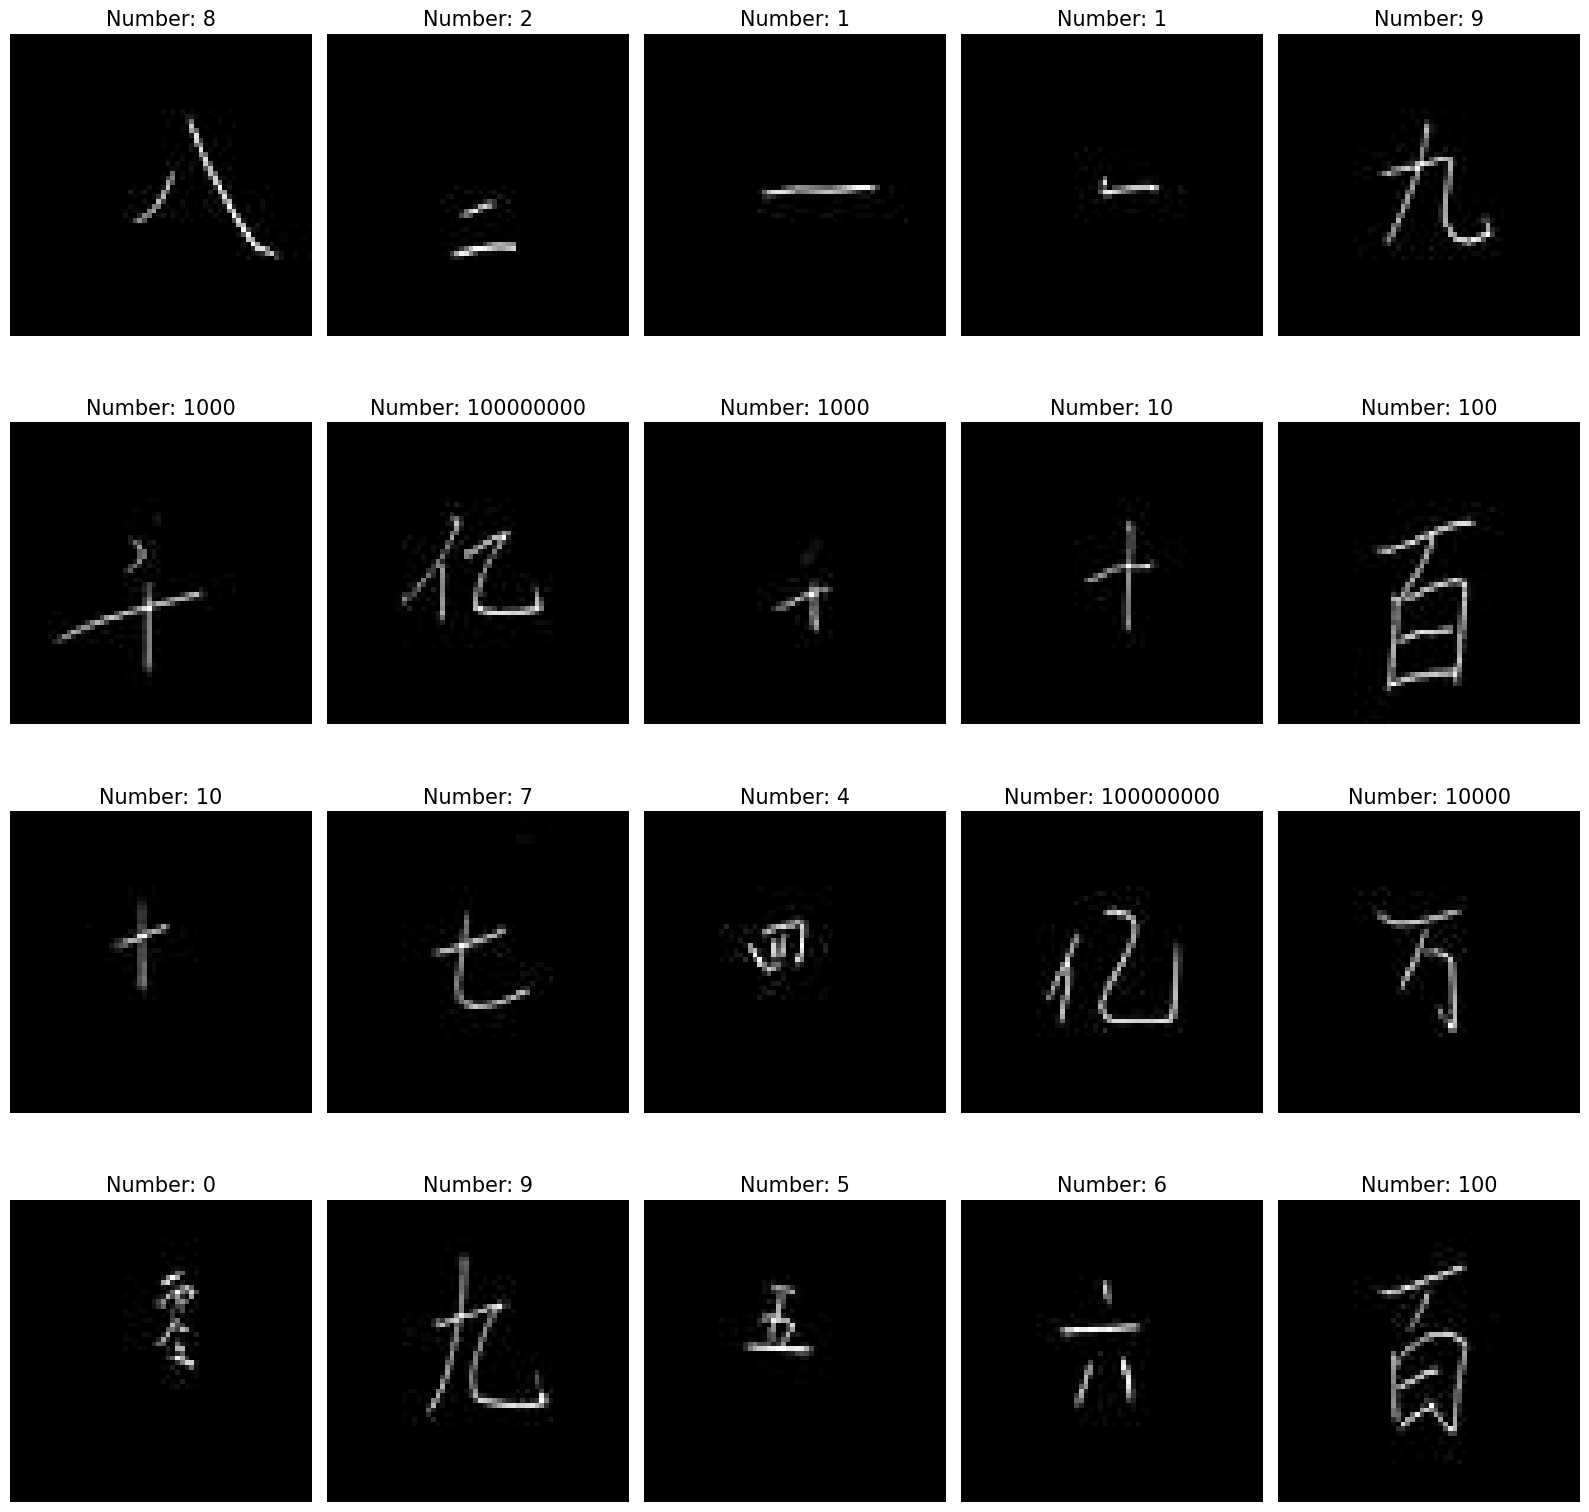

In [7]:
fig, axes = plt.subplots(4, 5, figsize=(16, 16))
for i in range(20):
    ax = axes.flat[i]
    num = np.random.randint(0, len(df)) 
    ax.imshow(PIL.Image.open('chinese_mnist/data/' + df.image_name[num]), 'gray')
    ax.set_title(f'Number: {df.value[num]}', size=15)
    ax.axis('off')
plt.tight_layout()
plt.show();

The values and characters match in above images. Further check for sure.

In [8]:
print(*zip(df.value.unique(), df.character.unique()))

(0, '零') (1, '一') (2, '二') (3, '三') (4, '四') (5, '五') (6, '六') (7, '七') (8, '八') (9, '九') (10, '十') (100, '百') (1000, '千') (10000, '万') (100000000, '亿')


Add a "label" column, changing the "big" values with "small" ones for simplicity.

In [9]:
df[df.value > 10].head()

,ori_index,suite_id,sample_id,code,value,character,image_name
11,2000,1,1,12,100,百,input_1_1_12.jpg
12,3000,1,1,13,1000,千,input_1_1_13.jpg
13,4000,1,1,14,10000,万,input_1_1_14.jpg
14,5000,1,1,15,100000000,亿,input_1_1_15.jpg
26,2002,1,2,12,100,百,input_1_2_12.jpg


In [10]:
df['label'] = df['value'].replace({100: 11, 1000: 12, 10000: 13, 100000000: 14})
df[df.value > 10].head()

,ori_index,suite_id,sample_id,code,value,character,image_name,label
11,2000,1,1,12,100,百,input_1_1_12.jpg,11
12,3000,1,1,13,1000,千,input_1_1_13.jpg,12
13,4000,1,1,14,10000,万,input_1_1_14.jpg,13
14,5000,1,1,15,100000000,亿,input_1_1_15.jpg,14
26,2002,1,2,12,100,百,input_1_2_12.jpg,11


### Data split  

We split the images into training and test/validation sets by random sampling. The test size is 0.25.

In [11]:
train_df = df.sample(frac=0.75, replace=False, random_state=0)
train_images = train_df.image_name.values

test_index = list(set(df.index) - set(train_df.index))
test_df = df.iloc[test_index, :]
test_images = test_df.image_name.values

y_train = train_df.label
y_test = test_df.label

print('train images:', len(train_images))
print('test images:', len(test_images))
print('test labels:', len(y_train))
print('test labels:', len(y_test))

train images: 11250
test images: 3750
test labels: 11250
test labels: 3750


In [12]:
# Make copies for later use.
train_df2, test_df2 = train_df, test_df

In [13]:
train_df = train_df.reset_index().drop('index', axis=1)
test_df = test_df.reset_index().drop('index', axis=1)
train_df.head()

,ori_index,suite_id,sample_id,code,value,character,image_name,label
0,11042,12,2,6,5,五,input_12_2_6.jpg,5
1,5902,90,2,15,100000000,亿,input_90_2_15.jpg,14
2,10663,69,3,5,4,四,input_69_3_5.jpg,4
3,265,32,5,10,9,九,input_32_5_10.jpg,9
4,4427,47,7,14,10000,万,input_47_7_14.jpg,13


In [14]:
test_df.head()

,ori_index,suite_id,sample_id,code,value,character,image_name,label
0,6000,1,1,1,0,零,input_1_1_1.jpg,0
1,8517,55,7,3,2,二,input_55_7_3.jpg,2
2,8000,1,1,3,2,二,input_1_1_3.jpg,2
3,10517,55,7,5,4,四,input_55_7_5.jpg,4
4,517,55,7,10,9,九,input_55_7_10.jpg,9


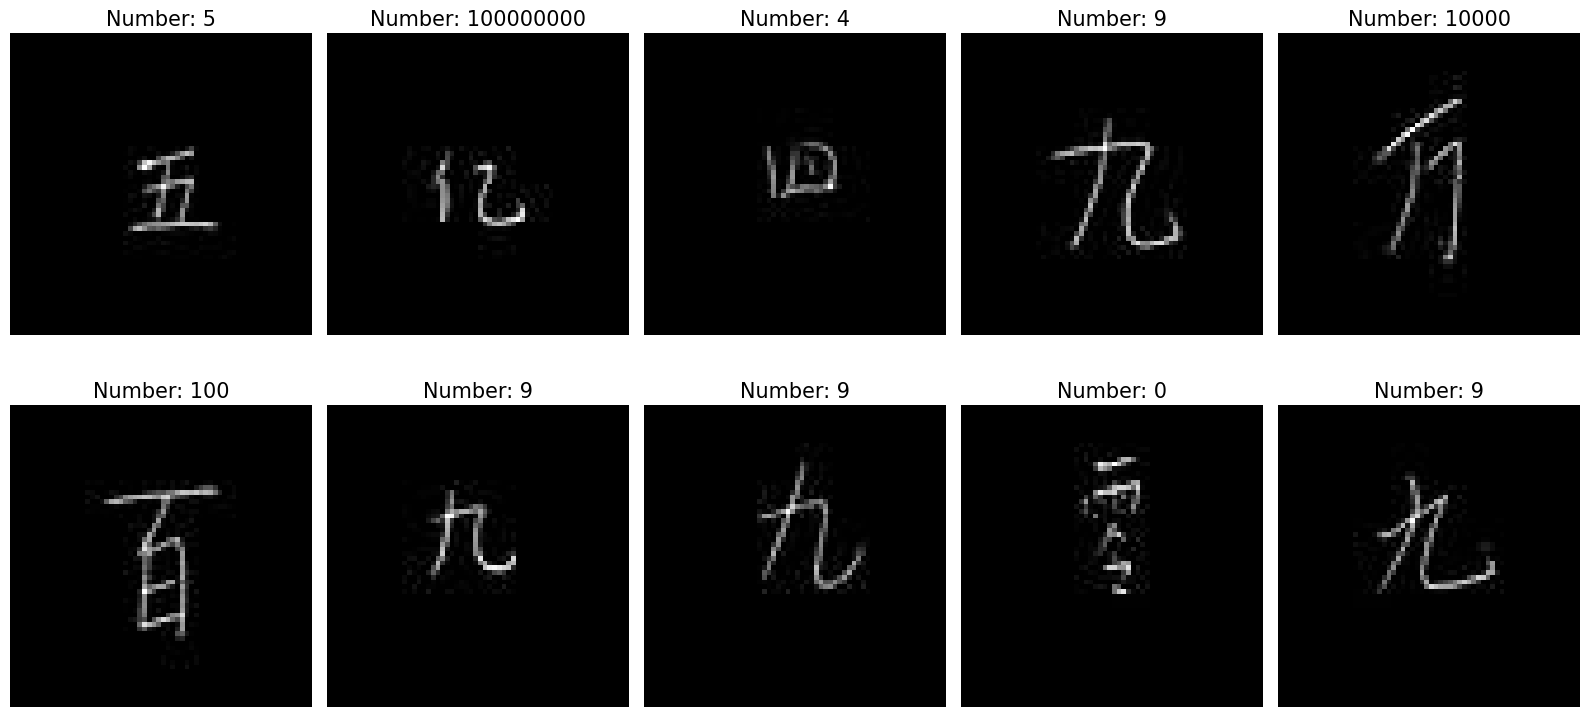

In [15]:
# Again make sure images and their value match after split.
y_train_value = train_df.value
y_test_value = test_df.value

fig, axes = plt.subplots(2, 5, figsize=(16, 8))
for i in range(10):
    ax = axes.flat[i]
    ax.imshow(PIL.Image.open('chinese_mnist/data/' + train_images[i]), 'gray')
    character = y_train_value[y_train_value.index==train_df.index[i]].values[0]
    ax.set_title(f'Number: {character}', size=15)
    ax.axis('off')
plt.tight_layout()
plt.show();

We extract the labels corresponding to the training and test/validation sets (y_train, y_test, and then use keras to_categorical() function to do one-hot coding for the labels. The class numer is 15.

In [16]:
y_train = keras.utils.to_categorical(y_train, 15)
y_test = keras.utils.to_categorical(y_test, 15)
print(y_train.shape)
print(y_test.shape)

(11250, 15)
(3750, 15)


Convert the image data into numpy arrays.

In [17]:
train_array = [np.array(PIL.Image.open('chinese_mnist/data/' + i)) for i in train_images]
train_array = np.array(train_array)

test_array = [np.array(PIL.Image.open('chinese_mnist/data/' + i)) for i in test_images]
test_array = np.array(test_array)

print('train image array shape:', train_array.shape )
print('test image array shape:', test_array.shape)

train image array shape: (11250, 64, 64)
test image array shape: (3750, 64, 64)


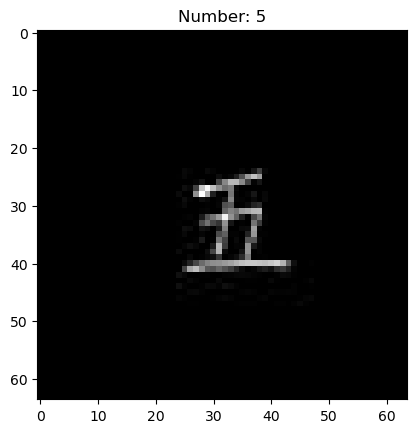

In [18]:
plt.imshow(train_array[0], 'gray')
plt.title(f'Number: {y_train_value.values[0]}');

In [19]:
# Make copies
train_array_copy = train_array
test_array_copy = test_array

Normalization and reshaping for neural network.

In [20]:
# Normalize the array values and reshape
# Ready to go!
train_array = train_array.astype(float)/255
test_array = test_array.astype(float)/255

train_array = train_array.reshape(*train_array.shape, 1)
test_array = test_array.reshape(*test_array.shape, 1)
train_array.shape, test_array.shape

train_array.shape
test_array.shape

(3750, 64, 64, 1)

### Training

#### CNN models

##### Basic CNN model
We constructed a CNN model with three Conv2D layers with ReLU activation, each followed by a MaxPooling2D and a Dropout layer for regularization. These are followed by a Flatten layers and then a Dense layer with softmax activation to output 15 class probability.

In [24]:
# Construct network
img_height = 64
img_width = 64
batch_size = 32

# CNN model
inputs = Input(shape=(64, 64, 1))

# One
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
# Two
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
# Three
x = Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Flatten()(x)

# Final
outputs = Dense(15, activation='softmax')(x)

cnn1 = Model(inputs, outputs, name='cnn1')
cnn1.summary()

Model: "cnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │          30,735 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,407 (482.06 KB)

 Trainable params: 123,407 (482.06 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Save the summary for report writing.
from contextlib import redirect_stdout
with open('cnn1_summary.txt', 'w') as f:
    with redirect_stdout(f):
        cnn1.summary()

Model: "cnn1"

+--------------------------------------------------------------------------------------+
| Layer (type)                         | Output Shape                |         Param # |
|--------------------------------------+-----------------------------+-----------------|
| input_layer_1 (InputLayer)           | (None, 64, 64, 1)           |               0 |
|--------------------------------------+-----------------------------+-----------------|
| conv2d_3 (Conv2D)                    | (None, 32, 32, 32)          |             320 |
|--------------------------------------+-----------------------------+-----------------|
| max_pooling2d_3 (MaxPooling2D)       | (None, 32, 32, 32)          |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dropout_3 (Dropout)                  | (None, 32, 32, 32)          |               0 |
|--------------------------------------+-----------------------------+-----------------|
| conv2d_4 (Conv2D)                    | (None, 16, 16, 64)          |          18,496 |
|--------------------------------------+-----------------------------+-----------------|
| max_pooling2d_4 (MaxPooling2D)       | (None, 16, 16, 64)          |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dropout_4 (Dropout)                  | (None, 16, 16, 64)          |               0 |
|--------------------------------------+-----------------------------+-----------------|
| conv2d_5 (Conv2D)                    | (None, 8, 8, 128)           |          73,856 |
|--------------------------------------+-----------------------------+-----------------|
| max_pooling2d_5 (MaxPooling2D)       | (None, 4, 4, 128)           |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dropout_5 (Dropout)                  | (None, 4, 4, 128)           |               0 |
|--------------------------------------+-----------------------------+-----------------|
| flatten_1 (Flatten)                  | (None, 2048)                |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dense_1 (Dense)                      | (None, 15)                  |          30,735 |
+--------------------------------------------------------------------------------------+

 Total params: 123,407 (482.06 KB)

 Trainable params: 123,407 (482.06 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
cnn1.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history1 = cnn1.fit(train_array, y_train, 
                  epochs=10,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.3926 - loss: 1.8750 - val_accuracy: 0.8432 - val_loss: 0.4826
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8552 - loss: 0.4504 - val_accuracy: 0.9107 - val_loss: 0.2924
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9174 - loss: 0.2534 - val_accuracy: 0.9339 - val_loss: 0.2029
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9344 - loss: 0.2058 - val_accuracy: 0.9451 - val_loss: 0.1796
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9396 - loss: 0.1667 - val_accuracy: 0.9605 - val_loss: 0.1245
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9626 - loss: 0.1208 - val_accuracy: 0.9555 - val_loss: 0.1376
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9650 - loss: 0.1083 - val_accuracy: 0.9717 - val_loss: 0.1020
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9668 - loss: 0.1079 - val_accuracy: 0.

Evaluate the model. Both curves appear to be leveling off.

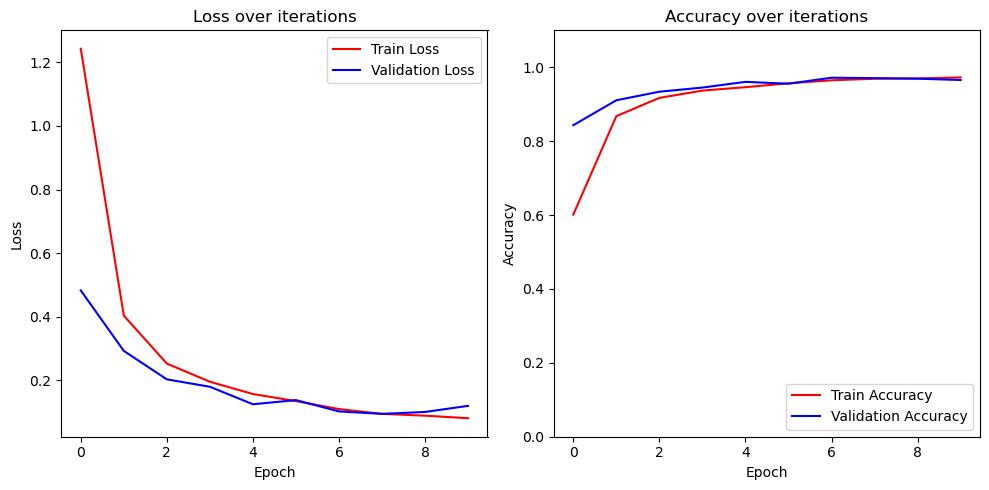

In [27]:
def display_metrics(history):

    n = len(history.history["loss"])

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(range(n), (history.history["loss"]),'r', label="Train Loss")
    ax.plot(range(n), (history.history["val_loss"]),'b', label="Validation Loss")
    ax.legend()
    ax.set_title('Loss over iterations')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(n), (history.history["accuracy"]),'r', label="Train Accuracy")
    ax.plot(range(n), (history.history["val_accuracy"]),'b', label="Validation Accuracy")
    ax.legend(loc='lower right')
    ax.set_title('Accuracy over iterations')
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    
    plt.tight_layout()

display_metrics(history1)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 2000x2000 with 0 Axes>

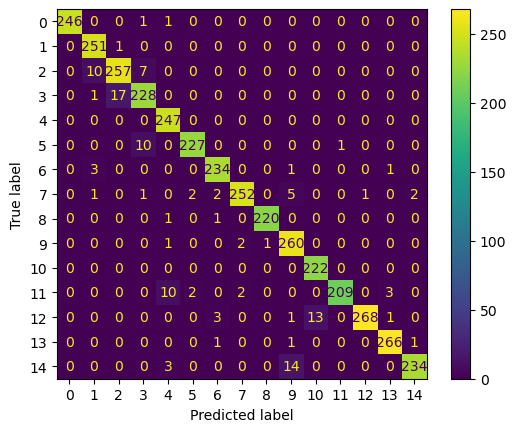

In [51]:
y_test_label = test_df.label
y_predict_prob = cnn1.predict(test_array)
y_predict = y_predict_prob.argmax(axis=1)

figure = plt.figure(figsize=(20, 20))
cf = confusion_matrix(y_test_label, y_predict)
display = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=list(range(15)))
display.plot();

#### Adjust the network structure

For exploration, we manually adjusted the structures and ran 10 epochs for each model while keeping all other hyperparameters constant. All the validation accuracy curves leveled off after 10 epochs except the two two-Conv2D models, but their curves leveled off after another two epochs without much improvement in validation accuracy (not shown).  

1. Delete the first Conv2D layer. Worse compared to cnn1. Worse (lower accuracy).

Model: "cnn2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │         122,895 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 197,391 (771.06 KB)

 Trainable params: 197,391 (771.06 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4302 - loss: 1.8111 - val_accuracy: 0.7573 - val_loss: 0.7168
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8133 - loss: 0.5743 - val_accuracy: 0.8523 - val_loss: 0.4527
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8727 - loss: 0.3970 - val_accuracy: 0.8893 - val_loss: 0.3424
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9105 - loss: 0.2761 - val_accuracy: 0.9184 - val_loss: 0.2725
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9266 - loss: 0.2279 - val_accuracy: 0.9139 - val_loss: 0.2557
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9349 - loss: 0.1929 - val_accuracy: 0.9181 - val_loss: 0.2629
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9521 - loss: 0.1513 - val_accuracy: 0.9320 - val_loss: 0.2151
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9563 - loss: 0.1319 - val

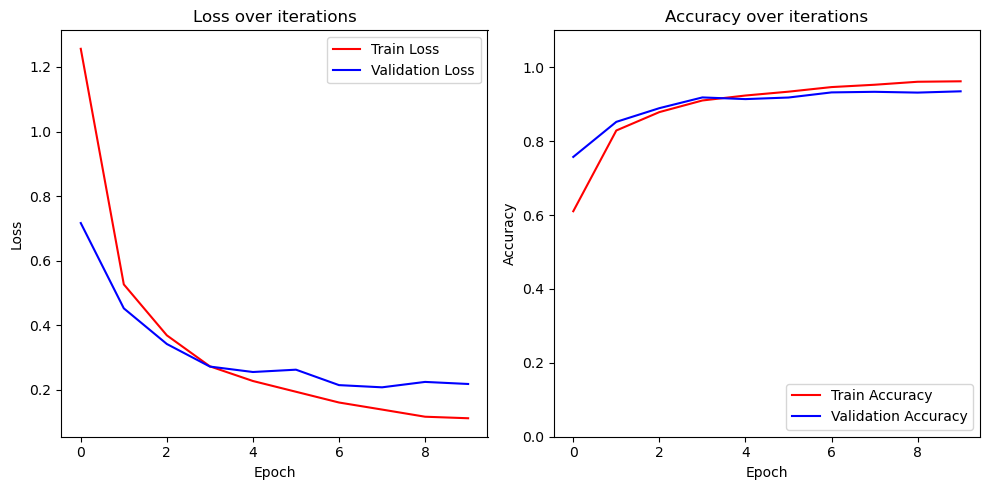

In [52]:
inputs = Input(shape=(64, 64, 1))
# x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
# x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
# x = Dropout(0.2)(x)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(15, activation='softmax')(x)

cnn2 = Model(inputs, outputs, name='cnn2')
print(cnn2.summary())

cnn2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history2 = cnn2.fit(train_array, y_train, 
                  epochs=10,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

display_metrics(history2);

2. Delete the first Conv2D, but increase the filters of second Conv2D (64 to 256). Worse.

Model: "cnn3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │         122,895 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,495 (1.60 MB)

 Trainable params: 420,495 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.4640 - loss: 1.6992 - val_accuracy: 0.8229 - val_loss: 0.5751
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.8401 - loss: 0.5073 - val_accuracy: 0.8445 - val_loss: 0.4710
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.8916 - loss: 0.3302 - val_accuracy: 0.8883 - val_loss: 0.3366
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.9261 - loss: 0.2309 - val_accuracy: 0.9027 - val_loss: 0.2993
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9354 - loss: 0.1976 - val_accuracy: 0.9280 - val_loss: 0.2281
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 62ms/step - accuracy: 0.9500 - loss: 0.1539 - val_accuracy: 0.9171 - val_loss: 0.2483
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.9564 - loss: 0.1250 - val_accuracy: 0.9144 - val_loss: 0.2790
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.9577 - loss: 0.12

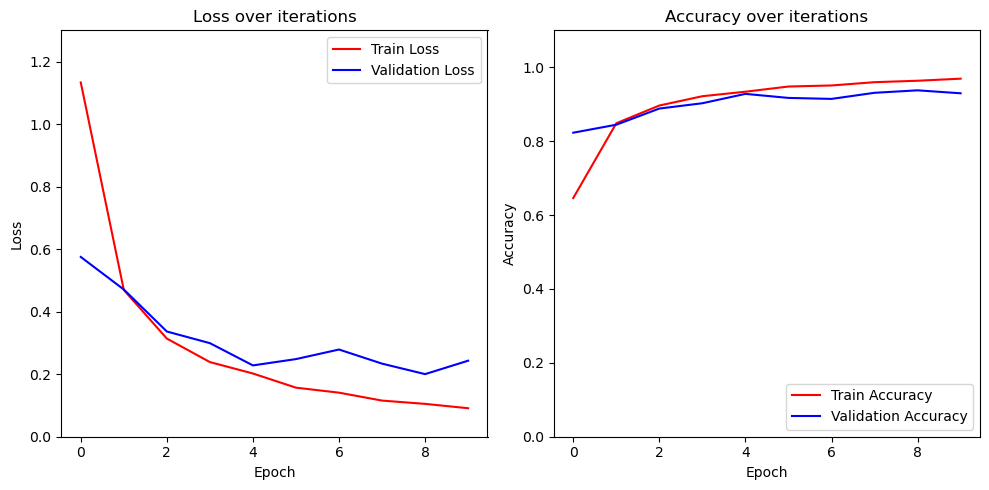

In [34]:
inputs = Input(shape=(64, 64, 1))
# x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
# x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
# x = Dropout(0.2)(x)
# x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(256, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(15, activation='softmax')(x)

cnn3 = Model(inputs, outputs, name='cnn3')
print(cnn3.summary())

cnn3.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history3 = cnn3.fit(train_array, y_train, 
                  epochs=10,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

display_metrics(history3);

3. Same structure of cnn1, but increase the filters of layer 1 and 2 (32 to 64, 64 to 128, respectively). Worse.

Model: "cnn4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 15)                  │         122,895 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 271,759 (1.04 MB)

 Trainable params: 271,759 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.4519 - loss: 1.7233 - val_accuracy: 0.7981 - val_loss: 0.6167
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8309 - loss: 0.5241 - val_accuracy: 0.8533 - val_loss: 0.4244
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8882 - loss: 0.3493 - val_accuracy: 0.8984 - val_loss: 0.3272
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9132 - loss: 0.2616 - val_accuracy: 0.8981 - val_loss: 0.3033
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9280 - loss: 0.2024 - val_accuracy: 0.9176 - val_loss: 0.2565
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9408 - loss: 0.1713 - val_accuracy: 0.9229 - val_loss: 0.2456
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9553 - loss: 0.1309 - val_accuracy: 0.9141 - val_loss: 0.2668
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9552 - loss: 0.12

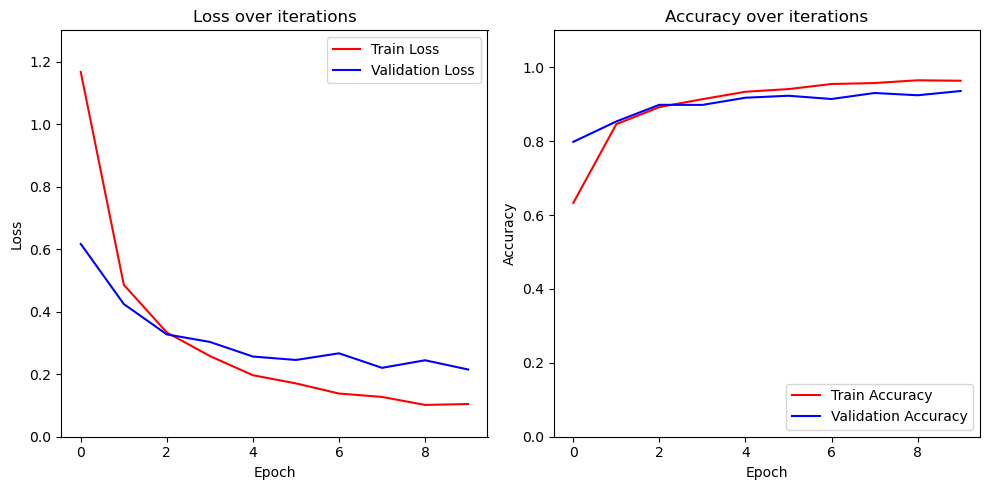

In [35]:
inputs = Input(shape=(64, 64, 1))
# x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
# x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(15, activation='softmax')(x)

cnn4 = Model(inputs, outputs, name='cnn4')
print(cnn4.summary())

cnn4.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history4 = cnn4.fit(train_array, y_train, 
                  epochs=10,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

display_metrics(history4)

4. Same as cnn1, but reduce the filters of Conv2D 3 (128 to 64). Worse.

Model: "cnn5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 15)                  │          61,455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 99,023 (386.81 KB)

 Trainable params: 99,023 (386.81 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3717 - loss: 1.9652 - val_accuracy: 0.7541 - val_loss: 0.7788
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7776 - loss: 0.6984 - val_accuracy: 0.8344 - val_loss: 0.5195
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8373 - loss: 0.5069 - val_accuracy: 0.8621 - val_loss: 0.4506
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8777 - loss: 0.3762 - val_accuracy: 0.8845 - val_loss: 0.3559
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8973 - loss: 0.3069 - val_accuracy: 0.8907 - val_loss: 0.3316
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9140 - loss: 0.2691 - val_accuracy: 0.9133 - val_loss: 0.2760
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9230 - loss: 0.2251 - val_accuracy: 0.9208 - val_loss: 0.2669
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9315 - loss: 0.2033 - val

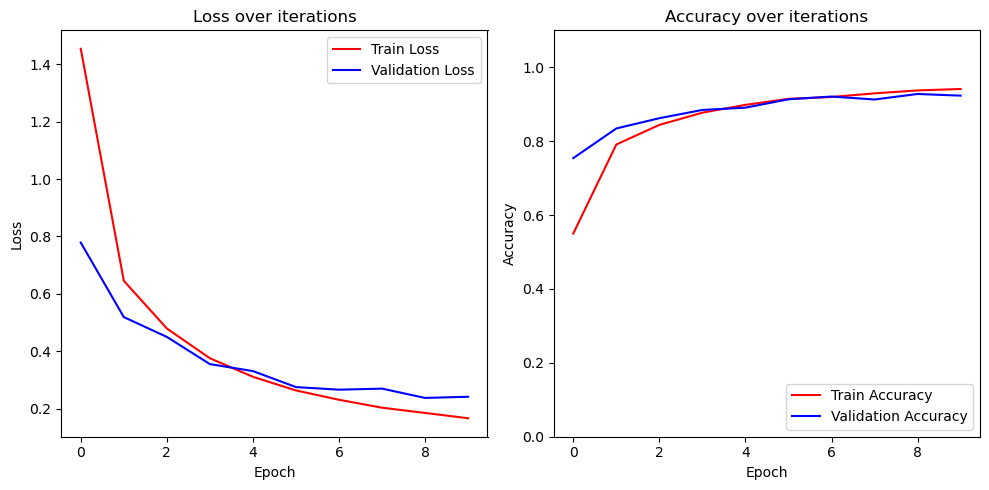

In [53]:
inputs = Input(shape=(64, 64, 1))
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(15, activation='softmax')(x)

cnn5 = Model(inputs, outputs, name='cnn5')
print(cnn5.summary())

cnn5.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history5 = cnn5.fit(train_array, y_train, 
                  epochs=10,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

display_metrics(history5)

5. Same as cnn1, but add a Conv2D after Conv2D 3. Close to cnn1.

Model: "cnn6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 2, 2, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 15)                  │             495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,703 (291.81 KB)

 Trainable params: 74,703 (291.81 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.2421 - loss: 2.2753 - val_accuracy: 0.8029 - val_loss: 0.6781
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7119 - loss: 0.8378 - val_accuracy: 0.8741 - val_loss: 0.3936
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8103 - loss: 0.5523 - val_accuracy: 0.9027 - val_loss: 0.3012
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8444 - loss: 0.4500 - val_accuracy: 0.9416 - val_loss: 0.1958
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8699 - loss: 0.3715 - val_accuracy: 0.9416 - val_loss: 0.1807
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8868 - loss: 0.3183 - val_accuracy: 0.9504 - val_loss: 0.1554
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9004 - loss: 0.2844 - val_accuracy: 0.9573 - val_loss: 0.1306
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9044 - loss: 0.2693 - val_acc

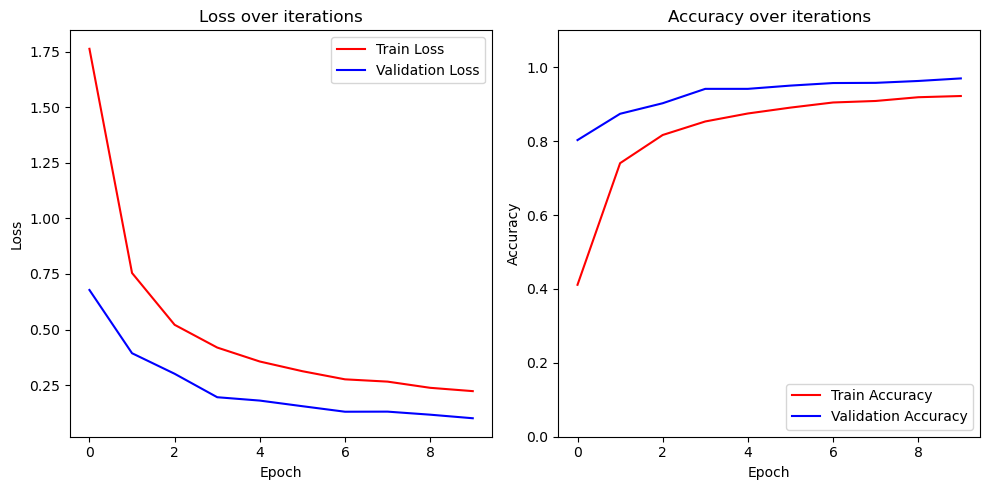

In [54]:
inputs = Input(shape=(64, 64, 1))
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(15, activation='softmax')(x)

cnn6 = Model(inputs, outputs, name='cnn6')
print(cnn6.summary())

cnn6.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history6 = cnn6.fit(train_array, y_train, 
                  epochs=10,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

display_metrics(history6)

cnn1, trained for another 5 epochs. Minor improvement. 

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9828 - loss: 0.0522 - val_accuracy: 0.9811 - val_loss: 0.0678
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9879 - loss: 0.0372 - val_accuracy: 0.9787 - val_loss: 0.0716
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9866 - loss: 0.0404 - val_accuracy: 0.9811 - val_loss: 0.0674
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9884 - loss: 0.0343 - val_accuracy: 0.9811 - val_loss: 0.0696
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9877 - loss: 0.0366 - val_accuracy: 0.9832 - val_loss: 0.0645


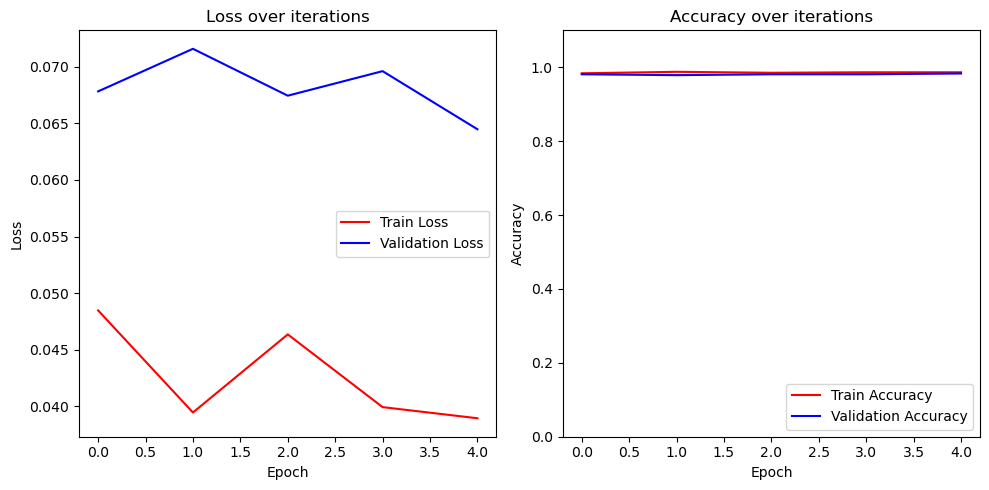

In [55]:
cnn1_15e = cnn1
history1_15e = cnn1_15e.fit(train_array, y_train, 
                  epochs=5,
                  batch_size=batch_size,
                  validation_data=(test_array, y_test),
                  shuffle=True)

display_metrics(history1_15e)

In [42]:
### Note (01/18/2025): the report used original training data.
loss_accuracy = []
historys = [history1, history2, history3, history4, history5, history6]
for history in historys:
    loss_accuracy.append({
        'train_loss': history.history['loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1]
    })
loss_accuracy_df = pd.DataFrame(loss_accuracy).round(3)
loss_accuracy_df

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.082,0.973,0.083,0.976
1,0.111,0.963,0.223,0.929
2,0.091,0.969,0.243,0.930
3,0.105,0.964,0.215,0.936
4,0.164,0.944,0.299,0.904
5,0.194,0.931,0.090,0.973


It appears the first model is the best among them, fast and achieved 0.976 validation accuracy after 10 epochs. Increasing units typically leads to an increase in the time of training.

#### Transfer learning model with VGG16

We would like to try a pretrained model for the dataset. We chose VGG16 as the base model for its relatively less layers compared to other models for this simple dataset.

##### Processing gray scale data to “RGB”
Because VGG16 were trained on color images, and we have grayscale images, so to be able to use the weights of VGG16, we convert the single channel of grayscale to three (“RGB”) using numpy repeat function.

In [31]:
train_array2 = [np.array(PIL.Image.open('chinese_mnist/data/' + i)) for i in train_images]
train_array2 = np.array(train_array2)/255

test_array2 = [np.array(PIL.Image.open('chinese_mnist/data/' + i)) for i in test_images]
test_array2 = np.array(test_array2)/255

train_stack = np.dstack((train_array2, train_array2, train_array2))
train_stack.shape

(11250, 64, 192)

In [32]:
# "Fake" RGB.
train_repeat = np.repeat((train_array2)[..., np.newaxis], 3, -1)
print(train_repeat.shape)

test_repeat = np.repeat((test_array2)[..., np.newaxis], 3, -1)
print(test_repeat.shape)

(11250, 64, 64, 3)
(3750, 64, 64, 3)


In [33]:
img_grayscale = Image.fromarray((train_array[0].reshape(*train_array[0].shape[0:2])*255).astype('uint8'))
img_grayscale.getbands()

('L',)

In [34]:
# Verify "RGB".
img_fakeRGB = Image.fromarray((train_repeat[0].reshape(*train_repeat[0].shape[0:3])*255).astype('uint8'))
img_fakeRGB.getbands()

('R', 'G', 'B')

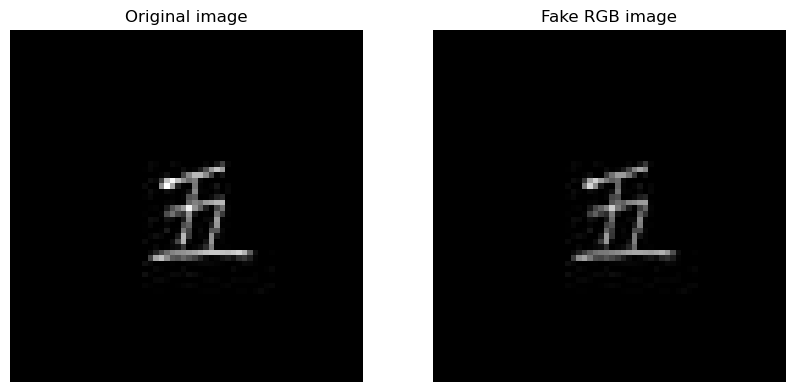

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img_grayscale, 'gray')
ax1.set_title('Original image') 
ax1.axis('off')
ax2.imshow(img_fakeRGB)
ax2.set_title('Fake RGB image')
ax2.axis('off')
plt.show()

Images before and after conversion look largely the same but there are some differences in density judged from the characters.

In [36]:
# Trying another method to increase channels
# Frim Medium
# https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a
train_repeat2 = np.expand_dims(train_array2, -1)
print(train_repeat2.shape)

train_repeat2_RGB = train_repeat2.repeat(3, axis=-1)
print(train_repeat2_RGB.shape)

test_repeat2 = np.expand_dims(test_array2, -1)
print(test_repeat2.shape)

test_repeat2_RGB = test_repeat2.repeat(3, axis=-1)
print(test_repeat2_RGB.shape)

(11250, 64, 64, 1)
(11250, 64, 64, 3)
(3750, 64, 64, 1)
(3750, 64, 64, 3)


In [37]:
# Using VGG16, 
# https://keras.io/api/applications/vgg/#vgg16-function
# https://arxiv.org/abs/1409.1556
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False, 
                  weights='imagenet',
                  input_shape=(64, 64, 3))
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

##### Model construction
The base model was VGG16 without top layers (13 Conv2D layers with units ranging from 4 to 64) and with “imagenet” weights. Input shape was changed to (64, 64, 3) for current data from the default (224, 224, 3). The trainable layers of the base model were frozen. The base model was followed by a Dense layer (64 units), a dropout layer (0.2), a flatten layer, and a Dense layer with softmax activation to output the classes (transfer learning model 1).

##### Training.
Try 10 epochs. The accuracy appears to be leveling off but the loss is still decreasing.  
The model is complex and slow to train.

2048
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 66s 184ms/step - accuracy: 0.3779 - loss: 2.0467 - val_accuracy: 0.8251 - val_loss: 0.8082
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.7228 - loss: 0.8695 - val_accuracy: 0.8733 - val_loss: 0.5096
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 73s 207ms/step - accuracy: 0.7962 - loss: 0.6260 - val_accuracy: 0.9021 - val_loss: 0.3804
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 92s 262ms/step - accuracy: 0.8474 - loss: 0.4890 - val_accuracy: 0.9136 - val_loss: 0.3325
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.8733 - loss: 0.4215 - val_accuracy: 0.9280 - val_loss: 0.2596
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 96s 273ms/step - accuracy: 0.8820 - loss: 0.3721 - val_accuracy: 0.9307 - val_loss: 0.2513
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 92s 263ms/step - accuracy: 0.8991 - loss: 0.3291 - val_accuracy: 0.9341 - val_loss: 0.2297
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 67s 190ms/step - accuracy: 0.9016 - l

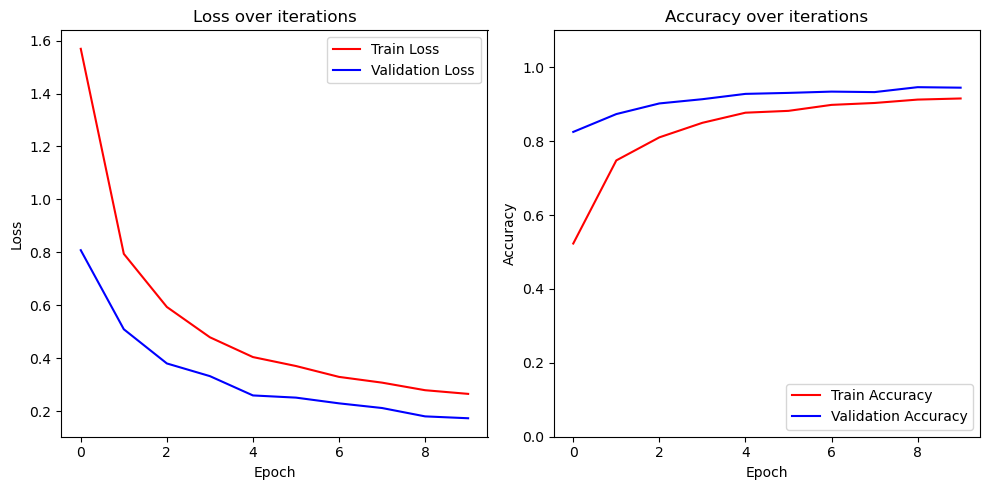

In [56]:
# All vgg layers
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze vgg layers
vgg_model.trainable = False
for layer in vgg_model.layers: 
    layer.trainable = False

input_shape = vgg_model.output_shape[1]
print(input_shape)

tl_model_16_1_10e = Sequential([
                vgg_model,
                Dense(64, activation='relu', input_dim=input_shape),
                Dropout(0.2),
                Flatten(),
                Dense(15, activation='softmax')])

tl_model_16_1_10e.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# 10 epochs
history_tl_16_1_10e = tl_model_16_1_10e.fit(train_repeat, y_train, 
                  epochs=10,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_16_1_10e)

In [ ]:
Add another 1o epochs. Some improvement and the accuracy curves are flat.

Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - accuracy: 0.9221 - loss: 0.2473 - val_accuracy: 0.9571 - val_loss: 0.1576
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.9212 - loss: 0.2493 - val_accuracy: 0.9605 - val_loss: 0.1485
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 82s 234ms/step - accuracy: 0.9305 - loss: 0.2262 - val_accuracy: 0.9571 - val_loss: 0.1400
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 91s 259ms/step - accuracy: 0.9304 - loss: 0.2092 - val_accuracy: 0.9584 - val_loss: 0.1429
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 72s 206ms/step - accuracy: 0.9344 - loss: 0.1990 - val_accuracy: 0.9635 - val_loss: 0.1252
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step - accuracy: 0.9385 - loss: 0.1940 - val_accuracy: 0.9645 - val_loss: 0.1217
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 85s 240ms/step - accuracy: 0.9402 - loss: 0.1921 - val_accuracy: 0.9637 - val_loss: 0.1214
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 65s 186ms/step - accuracy: 0.9423 - loss: 0

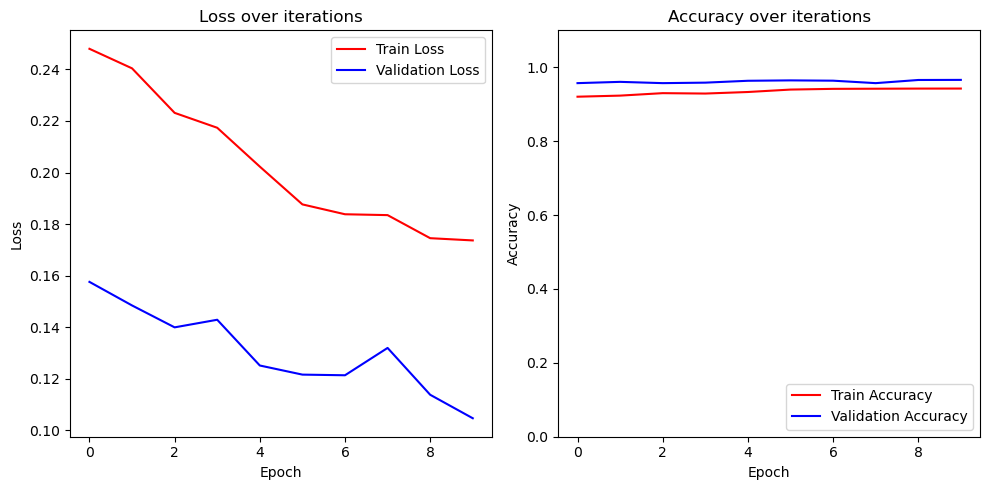

In [57]:
tl_model_16_1_10e_10e = tl_model_16_1_10e
history_tl_16_1_10e_10e = tl_model_16_1_10e_10e.fit(train_repeat, y_train, 
                  epochs=10,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_16_1_10e_10e)

Retrain for 20 epochs.

2048
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.4360 - loss: 1.8711 - val_accuracy: 0.8445 - val_loss: 0.6557
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.7813 - loss: 0.6963 - val_accuracy: 0.8899 - val_loss: 0.4062
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 173ms/step - accuracy: 0.8522 - loss: 0.4787 - val_accuracy: 0.9085 - val_loss: 0.3076
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 176ms/step - accuracy: 0.8776 - loss: 0.3990 - val_accuracy: 0.9288 - val_loss: 0.2447
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 180ms/step - accuracy: 0.9022 - loss: 0.3131 - val_accuracy: 0.9296 - val_loss: 0.2440
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.9179 - loss: 0.2820 - val_accuracy: 0.9443 - val_loss: 0.2033
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 67s 189ms/step - accuracy: 0.9214 - loss: 0.2543 - val_accuracy: 0.9459 - val_loss: 0.1772
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 70s 198ms/step - accuracy: 0.9245 - lo

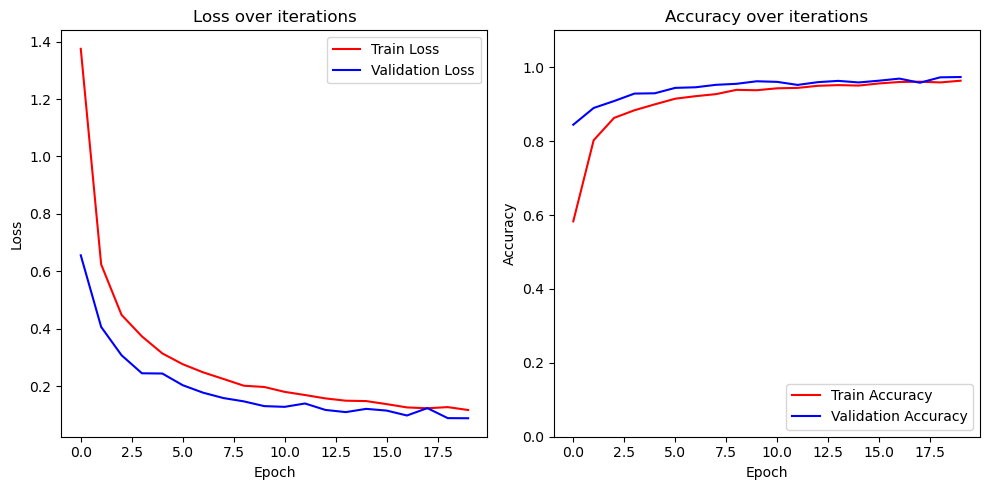

In [43]:
# All vgg layers
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze vgg layers
vgg_model.trainable = False
for layer in vgg_model.layers: 
    layer.trainable = False

input_shape = vgg_model.output_shape[1]
print(input_shape)

tl_model_16_1_20e = Sequential([
                vgg_model,
                Dense(64, activation='relu', input_dim=input_shape),
                Dropout(0.2),
                Flatten(),
                Dense(15, activation='softmax')])

tl_model_16_1_20e.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# 20 epochs
history_tl_16_1_20e = tl_model_16_1_20e.fit(train_repeat, y_train, 
                  epochs=20,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_16_1_20e)

In [ ]:
Retrain for 30 epochs. No improvement.

2048
Epoch 1/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 154ms/step - accuracy: 0.4177 - loss: 1.9073 - val_accuracy: 0.8253 - val_loss: 0.7371
Epoch 2/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 59s 166ms/step - accuracy: 0.7554 - loss: 0.7737 - val_accuracy: 0.8784 - val_loss: 0.4609
Epoch 3/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.8300 - loss: 0.5383 - val_accuracy: 0.9043 - val_loss: 0.3495
Epoch 4/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 174ms/step - accuracy: 0.8638 - loss: 0.4365 - val_accuracy: 0.9147 - val_loss: 0.2972
Epoch 5/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - accuracy: 0.8869 - loss: 0.3666 - val_accuracy: 0.9280 - val_loss: 0.2396
Epoch 6/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 71s 201ms/step - accuracy: 0.9047 - loss: 0.3117 - val_accuracy: 0.9307 - val_loss: 0.2231
Epoch 7/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 66s 188ms/step - accuracy: 0.9155 - loss: 0.2880 - val_accuracy: 0.9400 - val_loss: 0.2045
Epoch 8/30
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 180ms/step - accuracy: 0.9209 - lo

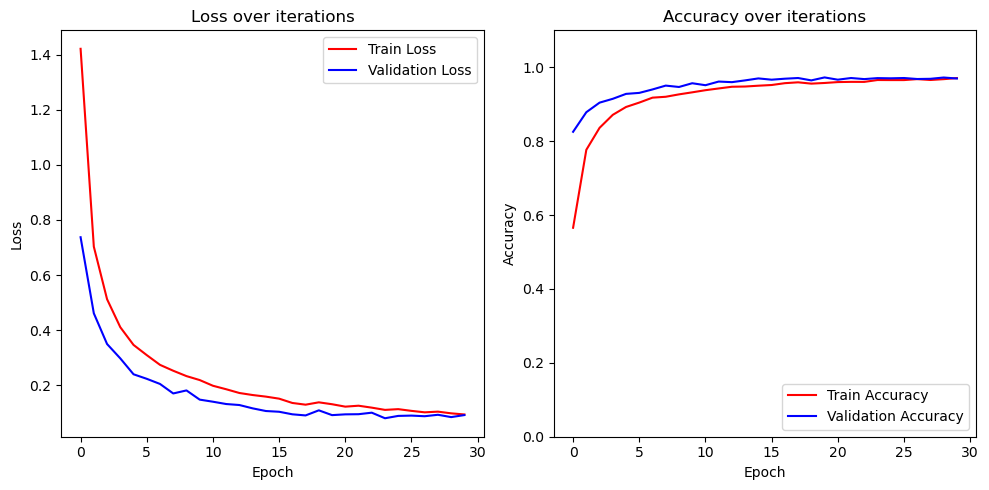

In [60]:
# All vgg layers
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze vgg layers
vgg_model.trainable = False
for layer in vgg_model.layers: 
    layer.trainable = False

input_shape = vgg_model.output_shape[1]
print(input_shape)

tl_model_16_1_30e = Sequential([
                vgg_model,
                Dense(64, activation='relu', input_dim=input_shape),
                Dropout(0.2),
                Flatten(),
                Dense(15, activation='softmax')])

tl_model_16_1_30e.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# 30 epochs
history_tl_16_1_30e = tl_model_16_1_30e.fit(train_repeat, y_train, 
                  epochs=30,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_16_1_30e)

Increase the first dense layer to 128, train for 20 epochs.

2048
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 58s 162ms/step - accuracy: 0.4773 - loss: 1.6939 - val_accuracy: 0.8563 - val_loss: 0.5662
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 177ms/step - accuracy: 0.8317 - loss: 0.5533 - val_accuracy: 0.8960 - val_loss: 0.3518
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 178ms/step - accuracy: 0.8798 - loss: 0.3804 - val_accuracy: 0.9261 - val_loss: 0.2557
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.9149 - loss: 0.2914 - val_accuracy: 0.9285 - val_loss: 0.2368
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 72s 204ms/step - accuracy: 0.9228 - loss: 0.2450 - val_accuracy: 0.9472 - val_loss: 0.1826
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 193ms/step - accuracy: 0.9332 - loss: 0.2188 - val_accuracy: 0.9485 - val_loss: 0.1583
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.9410 - loss: 0.1899 - val_accuracy: 0.9563 - val_loss: 0.1504
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.9503 - lo

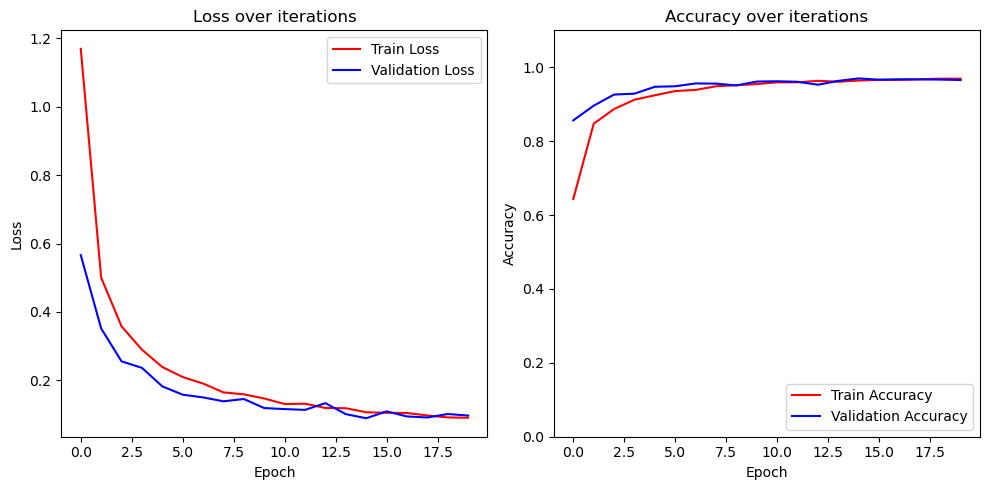

In [38]:
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze vgg layers
vgg_model.trainable = False
for layer in vgg_model.layers: 
    layer.trainable = False

input_shape = vgg_model.output_shape[1]
print(input_shape)

tl_model_16_2 = Sequential([
                vgg_model,
                Dense(128, activation='relu', input_dim=input_shape),
                Dropout(0.2),
                Flatten(),
                Dense(15, activation='softmax')])

tl_model_16_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_tl_16_2 = tl_model_16_2.fit(train_repeat, y_train, 
                  epochs=20,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_16_2)

In [ ]:
Delete the last Dense layer of VGG16 base model from the previous two models and repeated the experiment. Similar accuracy. 

8192
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 56s 156ms/step - accuracy: 0.4155 - loss: 1.8564 - val_accuracy: 0.8424 - val_loss: 0.6390
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 173ms/step - accuracy: 0.7428 - loss: 0.7893 - val_accuracy: 0.8979 - val_loss: 0.4088
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 61s 173ms/step - accuracy: 0.8130 - loss: 0.5679 - val_accuracy: 0.9304 - val_loss: 0.2916
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 175ms/step - accuracy: 0.8469 - loss: 0.4695 - val_accuracy: 0.9421 - val_loss: 0.2536
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.8667 - loss: 0.4130 - val_accuracy: 0.9483 - val_loss: 0.2096
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 66s 187ms/step - accuracy: 0.8820 - loss: 0.3550 - val_accuracy: 0.9483 - val_loss: 0.1976
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 65s 185ms/step - accuracy: 0.8859 - loss: 0.3464 - val_accuracy: 0.9533 - val_loss: 0.1754
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 181ms/step - accuracy: 0.8931 - lo

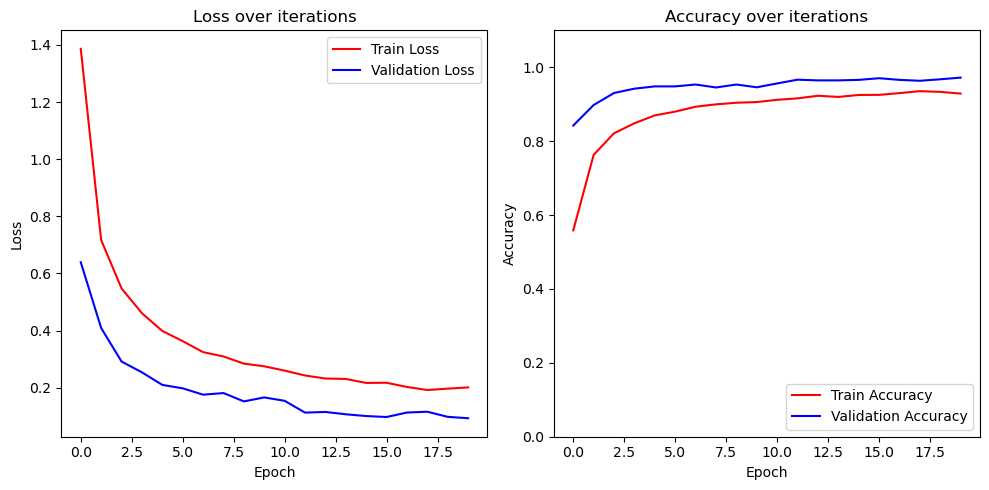

In [39]:
# Delete the last Dense layer
output = vgg.layers[-2].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze vgg layers
vgg_model.trainable = False
for layer in vgg_model.layers: 
    layer.trainable = False

input_shape = vgg_model.output_shape[1]
print(input_shape)

tl_model_15_1 = Sequential([
                vgg_model,
                Dense(64, activation='relu', input_dim=input_shape),
                Dropout(0.2),
                Flatten(),
                Dense(15, activation='softmax')])

tl_model_15_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_tl_15_1 = tl_model_15_1.fit(train_repeat, y_train, 
                  epochs=20,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_15_1)

In [ ]:
Delete the last Dense layer and increase first dense layer (64 to 128). Similar accuracy. 

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 154ms/step - accuracy: 0.4990 - loss: 1.5699 - val_accuracy: 0.8917 - val_loss: 0.4481
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 60s 169ms/step - accuracy: 0.8396 - loss: 0.5254 - val_accuracy: 0.9243 - val_loss: 0.2823
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 176ms/step - accuracy: 0.8877 - loss: 0.3628 - val_accuracy: 0.9381 - val_loss: 0.2259
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 179ms/step - accuracy: 0.9107 - loss: 0.2922 - val_accuracy: 0.9451 - val_loss: 0.1932
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 182ms/step - accuracy: 0.9256 - loss: 0.2352 - val_accuracy: 0.9509 - val_loss: 0.1661
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 182ms/step - accuracy: 0.9303 - loss: 0.2248 - val_accuracy: 0.9603 - val_loss: 0.1370
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 182ms/step - accuracy: 0.9468 - loss: 0.1814 - val_accuracy: 0.9459 - val_loss: 0.1634
Epoch 8/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 65s 184ms/step - accuracy: 0.9406 - loss: 0

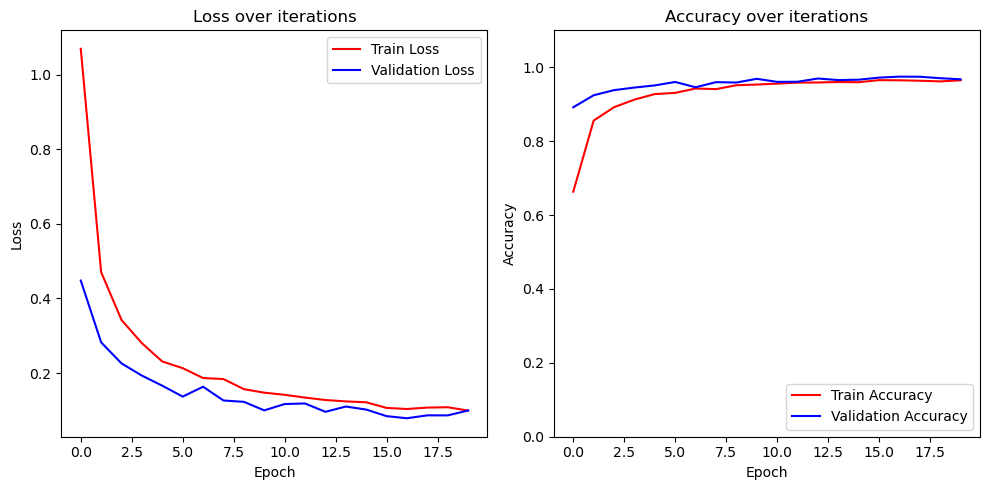

In [40]:
output = vgg.layers[-2].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

# Freeze vgg layers
vgg_model.trainable = False
for layer in vgg_model.layers: 
    layer.trainable = False

input_shape = vgg_model.output_shape[1]

tl_model_15_2 = Sequential([
                vgg_model,
                Dense(128, activation='relu', input_dim=input_shape),
                Dropout(0.2),
                Flatten(),
                Dense(15, activation='softmax')])

tl_model_15_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

history_tl_15_2 = tl_model_15_2.fit(train_repeat, y_train, 
                  epochs=20,
                  batch_size=32,
                  validation_data=(test_repeat, y_test),
                  shuffle=True)

display_metrics(history_tl_15_2)

In [48]:
loss_accuracy_tl = []
historys = [history_tl_16_1_20e, history_tl_16_2, history_tl_15_1, history_tl_15_2]
for history in historys:
    loss_accuracy_tl.append({
        'train_loss': history.history['loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'val_loss': history.history['val_loss'][-1],
        'val_accuracy': history.history['val_accuracy'][-1]
    })
loss_accuracy_tl_df = pd.DataFrame(loss_accuracy_tl).round(3)
loss_accuracy_tl_df

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.117,0.964,0.088,0.974
1,0.091,0.969,0.097,0.966
2,0.201,0.929,0.093,0.972
3,0.099,0.965,0.100,0.967


Comparison of confusion matrices of cnn1 and tl_15_2. Some subtle difference in correctly classification of individual characters. For example, the tranfer model is good at distinguishing "百" （label 11) from "四"（4）， but is worse in doing so for "千" (12) and "十"(10).

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Figure size 2000x2000 with 0 Axes>

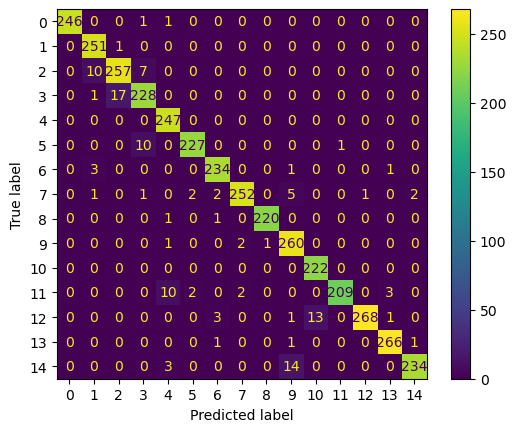

In [52]:
y_test_label = test_df.label
y_predict_prob = cnn1.predict(test_array)
y_predict = y_predict_prob.argmax(axis=1)

figure = plt.figure(figsize=(20, 20))
cf = confusion_matrix(y_test_label, y_predict)
display = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=list(range(15)))
display.plot();

118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step


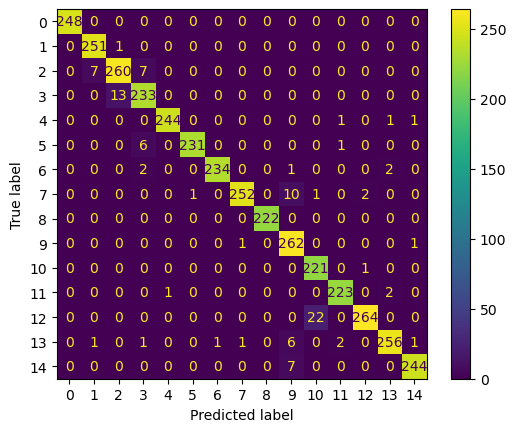

In [53]:
y_predict_prob_tl = tl_model_15_1.predict(test_repeat)
y_predict_tl = y_predict_prob_tl.argmax(axis=1)

cf_tl = confusion_matrix(y_test_label, y_predict_tl)
display = ConfusionMatrixDisplay(confusion_matrix=cf_tl, display_labels=list(range(15)))
display.plot();

### Summary of key findings and insights  

In this exercise, we used CNNs models to do multiple classification of grayscale images of hand-written Chinese number characters. A three Conv2D-layer construction (Figure 4, CNN model 1) achieved 0.97 classification accuracy. We modified the number of layers as well as layer units and found none was able to outperform the first configuration, and increasing units typically would increase training time. Additionally, we adapted VGG16 for the current classification task. The VGG16 transfer models appeared to perform consistently and gave similar or slightly better accuracy than CNN model 1, but at the cost of much longer training time. The reasons may include that the task is relatively simple and does not require such a complex CNN structure (deleting a layer from VGG16 didn’t reduce the performanc4), and that VGG16 was trained with color images and aims for large dataset. Finally, we found that the characters consisting of only horizontal strokes are harder for the model to correctly recognize and the transfer models are better than our CNN model in this aspect.

### Further data analysis and model improvement  

In this exercise, we only adjusted the Con2D layers of the CNN models. Therefore, there are other layers and hyperparameters, for example, pooling and dropout layers, learning rate, kernel size and strides, that can be optimized to improve the models. We could use kerasTuner to optimize these configurations. Similarly, we could fine-tune the VGG16 models to speed up the training while maintaining accuracy, although for this dataset, the complex model didn’t show great advantage. Apart from improving the model, we should also consider image augmentation which we didn’t implement here.
Finally, unlike MNIST, which contains far more “diverse” hand-written shapes for each number, the Chinese-MNIST is less challenging (except those “confusing” number characters mentioned before) to classify for the network because of the nature of the characters (less easy to mix up) and the images (collected from only 100 people). It would be interesting to use a large dataset, which may include other Chinese characters for the classification tas
.

Thank you!